In [3116]:
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import io

from src.utils.figure import plot_lines
from src.utils.file import get_data_file_path
from src.utils.file import get_evaluation_file_path
from src.utils.metrics import metrics

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Presentation

In [3117]:
presentation_row = 150
path = get_data_file_path(event_n=3, formula_n=3, count=2000)
data = pd.read_csv(path)

In [3118]:
data.head()

,context,query,question,code,formula,answer,graph
0,"Initially, event3 happened. After event1, even...",C1: Event1 happens or event2 happens.\nC2: C1 ...,"=== Context ===\n\nInitially, event3 happened....","MODULE main\nVAR\n state : {event1, event2,...",(X ((event1 | event2) & event1)),True,"<graphml xmlns=""http://graphml.graphdrawing.or..."
1,"Initially, event1 happened. After event3, no o...",C1: Event2 will happen eventually.\nC2: That e...,"=== Context ===\n\nInitially, event1 happened....","MODULE main\nVAR\n state : {event1, event2,...",(G (event2 -> (F event2))),True,"<graphml xmlns=""http://graphml.graphdrawing.or..."
2,"Initially, event2 happened. After event2, even...",C1: Event3 will happen at next time.\nC2: Even...,"=== Context ===\n\nInitially, event2 happened....","MODULE main\nVAR\n state : {event1, event2,...",((X event3) -> (X event3)),True,"<graphml xmlns=""http://graphml.graphdrawing.or..."
3,"Initially, event3 happened. After event1, even...",C1: Event2 happens and event3 happens.\nC2: Ev...,"=== Context ===\n\nInitially, event3 happened....","MODULE main\nVAR\n state : {event1, event2,...",(! (event1 | (event2 & event3))),True,"<graphml xmlns=""http://graphml.graphdrawing.or..."
4,"Initially, event2 happened. After event1, even...",C1: Event3 happens or event3 happens.\nC2: C1 ...,"=== Context ===\n\nInitially, event2 happened....","MODULE main\nVAR\n state : {event1, event2,...",(! ((event3 | event3) | event1)),True,"<graphml xmlns=""http://graphml.graphdrawing.or..."


In [3119]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   context   2000 non-null   object
 1   query     2000 non-null   object
 2   question  2000 non-null   object
 3   code      2000 non-null   object
 4   formula   2000 non-null   object
 5   answer    2000 non-null   bool  
 6   graph     2000 non-null   object
dtypes: bool(1), object(6)
memory usage: 95.8+ KB


In [3120]:
# Context
print(data.loc[presentation_row, 'context'])

Initially, event3 happened. After event1, event2 can happen. After event1, event3 can happen. After event2, no other events can happen. After event3, event1 can happen. After event3, event2 can happen.


In [3121]:
# Query 
print(data.loc[presentation_row, 'query'])

C1: Event2 will happen eventually.
C2: C1 will always be true at any future time.
C3: That event1 happens implies that C2 holds.


In [3122]:
# Question
print(data.loc[presentation_row, 'question'])

=== Context ===

Initially, event3 happened. After event1, event2 can happen. After event1, event3 can happen. After event2, no other events can happen. After event3, event1 can happen. After event3, event2 can happen.

=== Hypothesis ===

C1: Event2 will happen eventually.
C2: C1 will always be true at any future time.
C3: That event1 happens implies that C2 holds.

C3 is True or False? Answer with "True" or "False" directly:



In [3123]:
# Code
print(data.loc[presentation_row, 'code'])

MODULE main
VAR
    state : {event1, event2, event3};
ASSIGN
    init(state) := event3;
    next(state) := case
        state = event1 : event2;
		state = event1 : event3;
		state = event3 : event1;
		state = event3 : event2;
		state = event2 : event2;
    esac;
LTLSPEC ((state=event1) -> (G (F (state=event2))))



In [3124]:
# Formula
print(data.loc[presentation_row, 'formula'])

(event1 -> (G (F event2)))


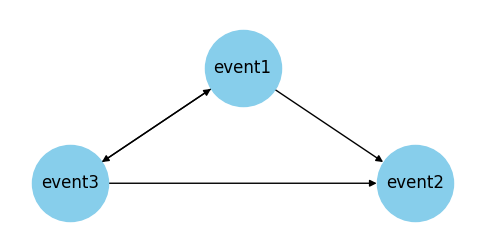

In [3125]:
# Plot Graph
graph = nx.read_graphml(io.StringIO(data.loc[presentation_row, 'graph']))
plt.figure(figsize=(6, 3))
plt.xlim(-1.35,1.35)
plt.ylim(-0.5,1.5)
pos = {"event1": (0, 1), "event2": (1, 0), "event3": (-1,0)}
nx.draw(graph, pos, with_labels=True, node_size=3000, node_color='skyblue')
plt.show()

In [3126]:
# Answer
print(data.loc[presentation_row, 'answer'])

True


# Prediction Presentation


In [3127]:
path = get_evaluation_file_path(event_n=3, formula_n=3, count=2000, model="gpt-3.5-turbo")
data = pd.read_csv(path)

In [3128]:
data.head()

,context,query,question,code,formula,answer,graph,prediction,prediction_raw
0,"Initially, event3 happened. After event1, even...",C1: Event1 happens or event2 happens.\nC2: C1 ...,"=== Context ===\n\nInitially, event3 happened....","MODULE main\nVAR\n state : {event1, event2,...",(X ((event1 | event2) & event1)),True,"<graphml xmlns=""http://graphml.graphdrawing.or...",1.0,True
1,"Initially, event1 happened. After event3, no o...",C1: Event2 will happen eventually.\nC2: That e...,"=== Context ===\n\nInitially, event1 happened....","MODULE main\nVAR\n state : {event1, event2,...",(G (event2 -> (F event2))),True,"<graphml xmlns=""http://graphml.graphdrawing.or...",1.0,True
2,"Initially, event2 happened. After event2, even...",C1: Event3 will happen at next time.\nC2: Even...,"=== Context ===\n\nInitially, event2 happened....","MODULE main\nVAR\n state : {event1, event2,...",((X event3) -> (X event3)),True,"<graphml xmlns=""http://graphml.graphdrawing.or...",1.0,True
3,"Initially, event3 happened. After event1, even...",C1: Event2 happens and event3 happens.\nC2: Ev...,"=== Context ===\n\nInitially, event3 happened....","MODULE main\nVAR\n state : {event1, event2,...",(! (event1 | (event2 & event3))),True,"<graphml xmlns=""http://graphml.graphdrawing.or...",0.0,False
4,"Initially, event2 happened. After event1, even...",C1: Event3 happens or event3 happens.\nC2: C1 ...,"=== Context ===\n\nInitially, event2 happened....","MODULE main\nVAR\n state : {event1, event2,...",(! ((event3 | event3) | event1)),True,"<graphml xmlns=""http://graphml.graphdrawing.or...",0.0,False


In [3129]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   context         2000 non-null   object 
 1   query           2000 non-null   object 
 2   question        2000 non-null   object 
 3   code            2000 non-null   object 
 4   formula         2000 non-null   object 
 5   answer          2000 non-null   bool   
 6   graph           2000 non-null   object 
 7   prediction      2000 non-null   float64
 8   prediction_raw  2000 non-null   bool   
dtypes: bool(2), float64(1), object(6)
memory usage: 113.4+ KB


In [3130]:
data['answer'] = data['answer'].apply(lambda x: 1 if x else 0)
data['prediction'] = data['prediction'].astype(int)

In [3131]:
# Accuracy
print(f'{len(data[data['answer'] == data['prediction']]) * 100 / len(data)}%')

55.0%


In [3132]:
# Prediction Distribution
data['prediction'].value_counts()

prediction
1    1288
0     712
Name: count, dtype: int64

In [3133]:
# Precision, Recall, F1
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(data['answer'], data['prediction'], average='macro')
recall = recall_score(data['answer'], data['prediction'], average='macro')
f1 = f1_score(data['answer'], data['prediction'], average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

Precision: 0.5545222974387606
Recall: 0.55
F1: 0.5404712110319587


# LLMs Evaluation

## 1. Event 3, Formula 3, Count 2000

In [3134]:
models = ["gpt-3.5-turbo", "llama3:70b-instruct", "qwen:72b-chat", "gemma:7b-instruct", "qwen:7b-chat",
          "mistral:7b-instruct"]

In [3135]:
models_metrics = {}
for model in models:
    path = get_evaluation_file_path(event_n=3, formula_n=3, count=2000, model=model)
    if not os.path.exists(path):
        warnings.warn(f"Evaluation file of model {model} does not exist.", UserWarning)
        continue
    data = pd.read_csv(path)
    data['answer'] = data['answer'].apply(lambda x: 1 if x else 0)
    data['prediction'] = data['prediction'].astype(int)
    models_metrics[model] = metrics(data)['raw']

df = pd.DataFrame(models_metrics)
df.transpose()

,accuracy,precision,recall,f1,auc
gpt-3.5-turbo,0.5500,0.554522,0.5500,0.540471,0.5500
llama3:70b-instruct,0.5895,0.591063,0.5895,0.587731,0.5895
qwen:72b-chat,0.5960,0.600429,0.5960,0.591496,0.5960
gemma:7b-instruct,0.5445,0.551603,0.5445,0.528268,0.5445
qwen:7b-chat,0.5435,0.543516,0.5435,0.543459,0.5435
mistral:7b-instruct,0.5440,0.570349,0.5440,0.496891,0.5440


In [3136]:
# large models mean
df.transpose().loc[['gpt-3.5-turbo', 'llama3:70b-instruct', 'qwen:72b-chat']].mean()

accuracy     0.578500
precision    0.582005
recall       0.578500
f1           0.573233
auc          0.578500
dtype: float64

In [3137]:
# small models mean
df.transpose().loc[['gemma:7b-instruct', 'qwen:7b-chat', 'mistral:7b-instruct']].mean()

accuracy     0.544000
precision    0.555156
recall       0.544000
f1           0.522872
auc          0.544000
dtype: float64

## 2. Event 2, Formula 1-9, Count 300

In [3138]:
event_n = 2
count = 300
formulas = [1, 2, 3, 4, 5, 7, 9]

models_data_df = pd.DataFrame()
for model in models:
    data = {}
    for formula_n in formulas:
        path = get_evaluation_file_path(event_n=event_n, formula_n=formula_n, count=count, model=model)
        if not os.path.exists(path):
            warnings.warn(f"Evaluation file of model {model} does not exist.", UserWarning)
            continue
        df = pd.read_csv(path)
        df['answer'] = df['answer'].apply(lambda x: 1 if x else 0)
        df['prediction'] = df['prediction'].astype(int)
        data[formula_n] = metrics(df)['raw']
    df = pd.DataFrame(data).transpose().reset_index().rename(columns={'index': 'number_of_operators'})
    df['model'] = model
    models_data_df = pd.concat([models_data_df, df], ignore_index=True)

models_data_df

,number_of_operators,accuracy,precision,recall,f1,auc,model
0,1,0.706667,0.716521,0.706667,0.703291,0.706667,gpt-3.5-turbo
1,2,0.580000,0.591912,0.580000,0.565936,0.580000,gpt-3.5-turbo
2,3,0.550000,0.557766,0.550000,0.534349,0.550000,gpt-3.5-turbo
3,4,0.590000,0.597267,0.590000,0.582196,0.590000,gpt-3.5-turbo
4,5,0.580000,0.584890,0.580000,0.573864,0.580000,gpt-3.5-turbo
5,7,0.566667,0.575000,0.566667,0.554286,0.566667,gpt-3.5-turbo
6,9,0.576667,0.579644,0.576667,0.572674,0.576667,gpt-3.5-turbo
7,1,0.646667,0.661892,0.646667,0.638159,0.646667,llama3:70b-instruct
8,2,0.603333,0.606286,0.603333,0.600559,0.603333,llama3:70b-instruct
9,3,0.630000,0.631692,0.630000,0.628808,0.630000,llama3:70b-instruct


### 2.1. Accuracy

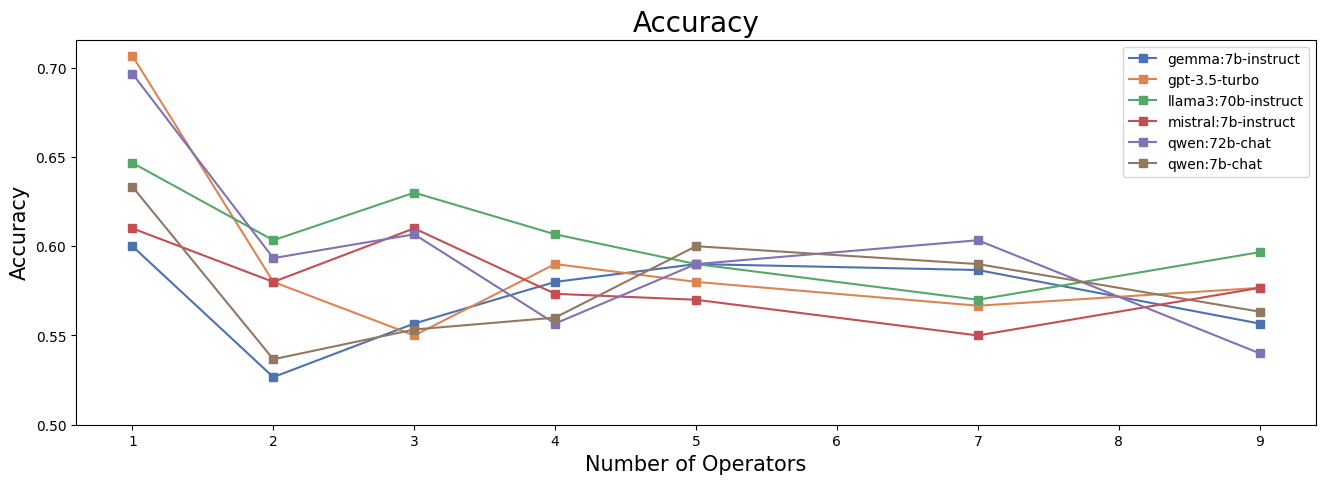

In [3139]:
x_ticks = list(np.arange(1, 10))
y_ticks = list(np.arange(0.5, 0.75, 0.05))
plot_lines(models_data_df, x='number_of_operators', y='accuracy', z='model', title='Accuracy', x_label='Number of Operators',
           y_label='Accuracy', x_ticks=x_ticks, y_ticks=y_ticks)

### 2.2. Precision

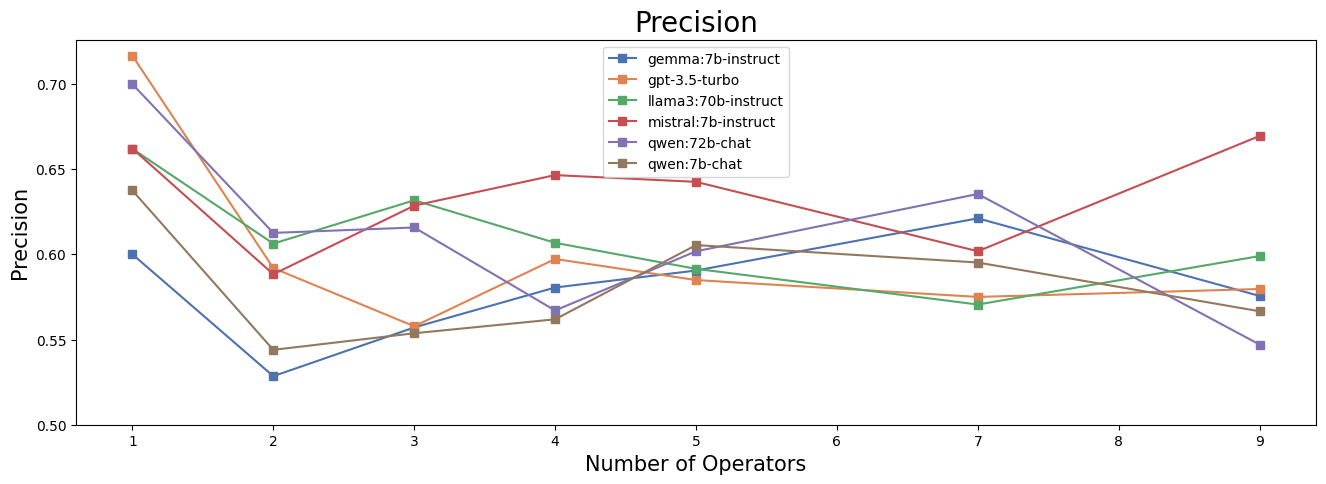

In [3140]:
x_ticks = list(np.arange(1, 10))
y_ticks = list(np.arange(0.5, 0.75, 0.05))
plot_lines(models_data_df, x='number_of_operators', y='precision', z='model', title='Precision', x_label='Number of Operators',
           y_label='Precision', x_ticks=x_ticks, y_ticks=y_ticks)

### 2.3. Recall

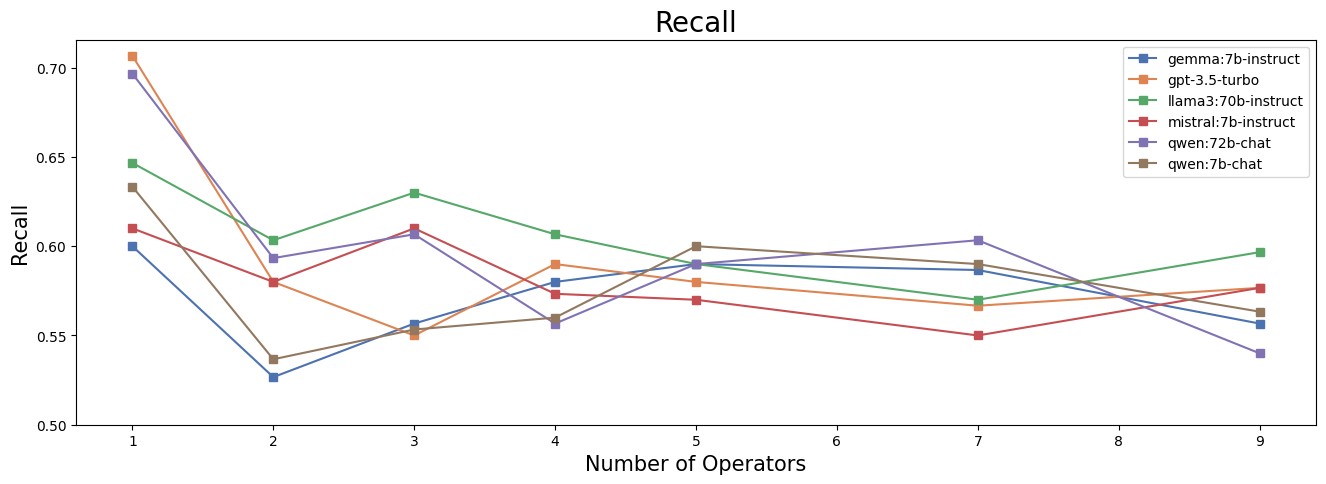

In [3141]:
x_ticks = list(np.arange(1, 10))
y_ticks = list(np.arange(0.5, 0.75, 0.05))
plot_lines(models_data_df, x='number_of_operators', y='recall', z='model', title='Recall', x_label='Number of Operators',
           y_label='Recall', x_ticks=x_ticks, y_ticks=y_ticks)

### 2.4. F1

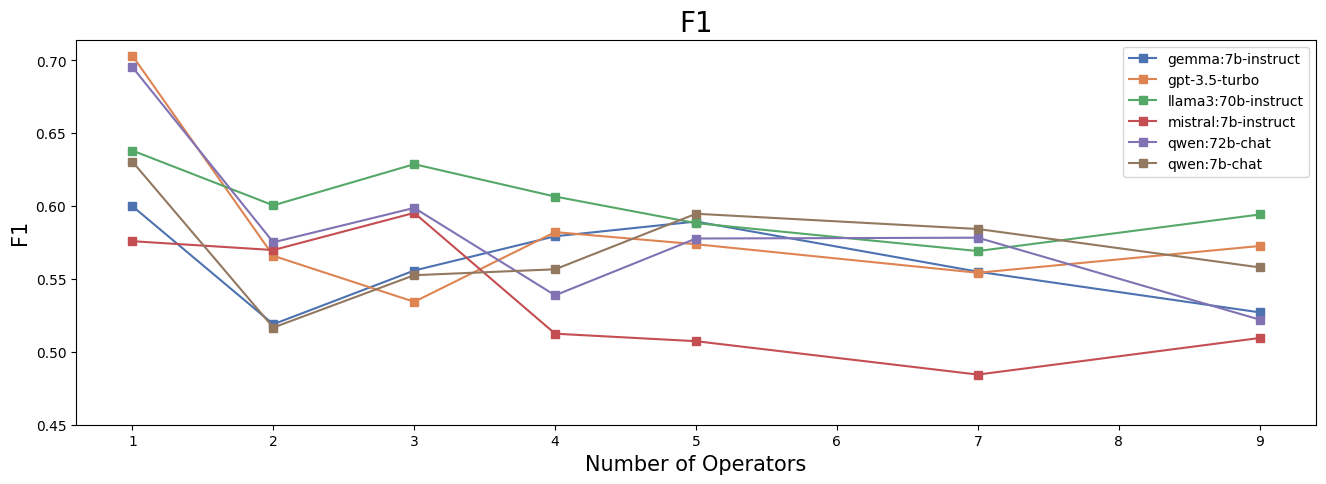

In [3142]:
x_ticks = list(np.arange(1, 10))
y_ticks = list(np.arange(0.45, 0.75, 0.05))
plot_lines(models_data_df, x='number_of_operators', y='f1', z='model', title='F1', x_label='Number of Operators', y_label='F1',
           x_ticks=x_ticks, y_ticks=y_ticks)

### 2.5. AUC

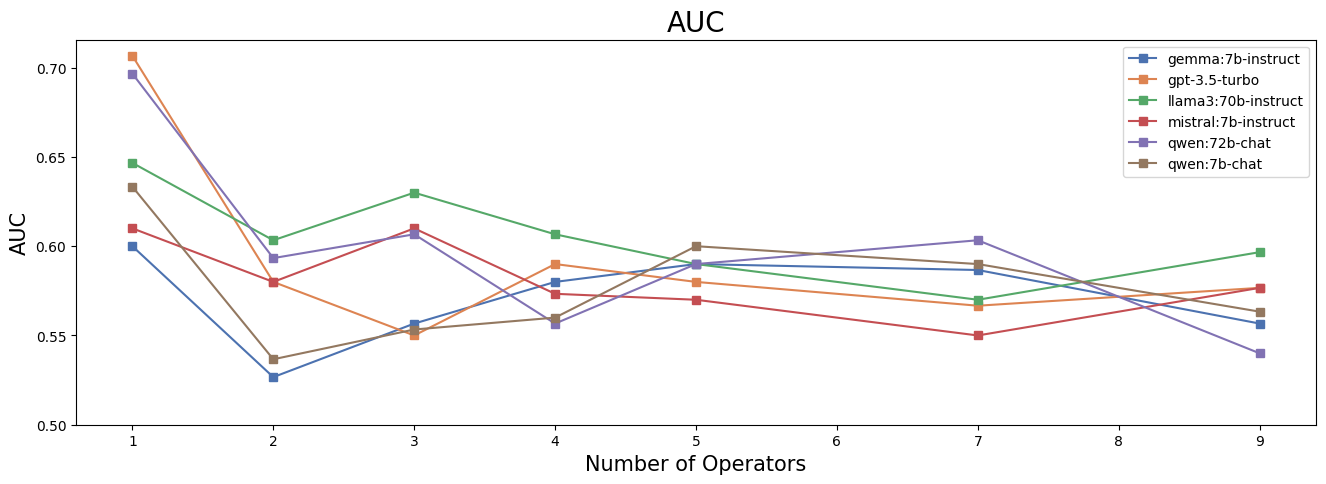

In [3143]:
x_ticks = list(np.arange(1, 10))
y_ticks = list(np.arange(0.5, 0.75, 0.05))
plot_lines(models_data_df, x='number_of_operators', y='auc', z='model', title='AUC', x_label='Number of Operators', y_label='AUC',
           x_ticks=x_ticks, y_ticks=y_ticks)

## 3. Formula 2, Event 2-9, Count 300

In [3144]:
count = 300
formulas = 2
events_n = [2, 3, 4, 5, 7, 9]

models_data_df = pd.DataFrame()
for model in models:
    data = {}
    for e_n in events_n:
        path = get_evaluation_file_path(event_n=e_n, formula_n=formulas, count=count, model=model)
        if not os.path.exists(path):
            warnings.warn(f"Evaluation file of model {model} does not exist.", UserWarning)
            continue
        df = pd.read_csv(path)
        df['answer'] = df['answer'].apply(lambda x: 1 if x else 0)
        df['prediction'] = df['prediction'].astype(int)
        data[e_n] = metrics(df)['raw']
    df = pd.DataFrame(data).transpose().reset_index().rename(columns={'index': 'number_of_events'})
    df['model'] = model
    models_data_df = pd.concat([models_data_df, df], ignore_index=True)

models_data_df

,number_of_events,accuracy,precision,recall,f1,auc,model
0,2,0.580000,0.591912,0.580000,0.565936,0.580000,gpt-3.5-turbo
1,3,0.510000,0.510576,0.510000,0.503239,0.510000,gpt-3.5-turbo
2,4,0.540000,0.540724,0.540000,0.537946,0.540000,gpt-3.5-turbo
3,5,0.543333,0.545267,0.543333,0.538405,0.543333,gpt-3.5-turbo
4,7,0.536667,0.538090,0.536667,0.532296,0.536667,gpt-3.5-turbo
5,9,0.520000,0.520525,0.520000,0.516908,0.520000,gpt-3.5-turbo
6,2,0.603333,0.606286,0.603333,0.600559,0.603333,llama3:70b-instruct
7,3,0.583333,0.584418,0.583333,0.581991,0.583333,llama3:70b-instruct
8,4,0.613333,0.615385,0.613333,0.611607,0.613333,llama3:70b-instruct
9,5,0.570000,0.570707,0.570000,0.568922,0.570000,llama3:70b-instruct


### 3.1. Accuracy

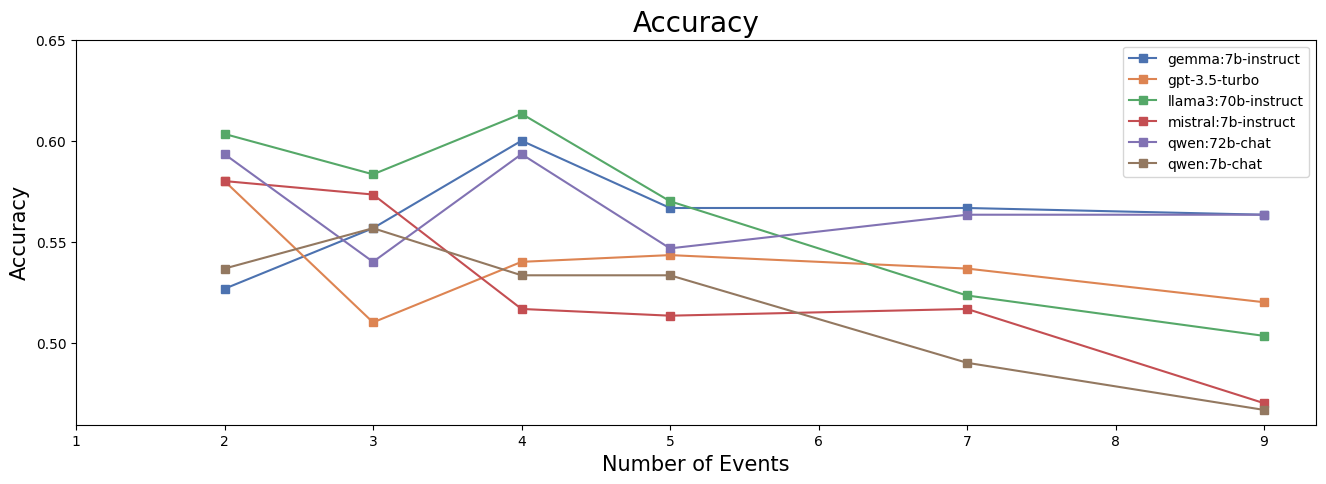

In [3145]:
x_ticks = list(np.arange(1, 10))
y_ticks = list(np.arange(0.5, 0.65, 0.05))
plot_lines(models_data_df, x='number_of_events', y='accuracy', z='model', title='Accuracy', x_label='Number of Events',
           y_label='Accuracy', x_ticks=x_ticks, y_ticks=y_ticks)

### 3.2. Precision

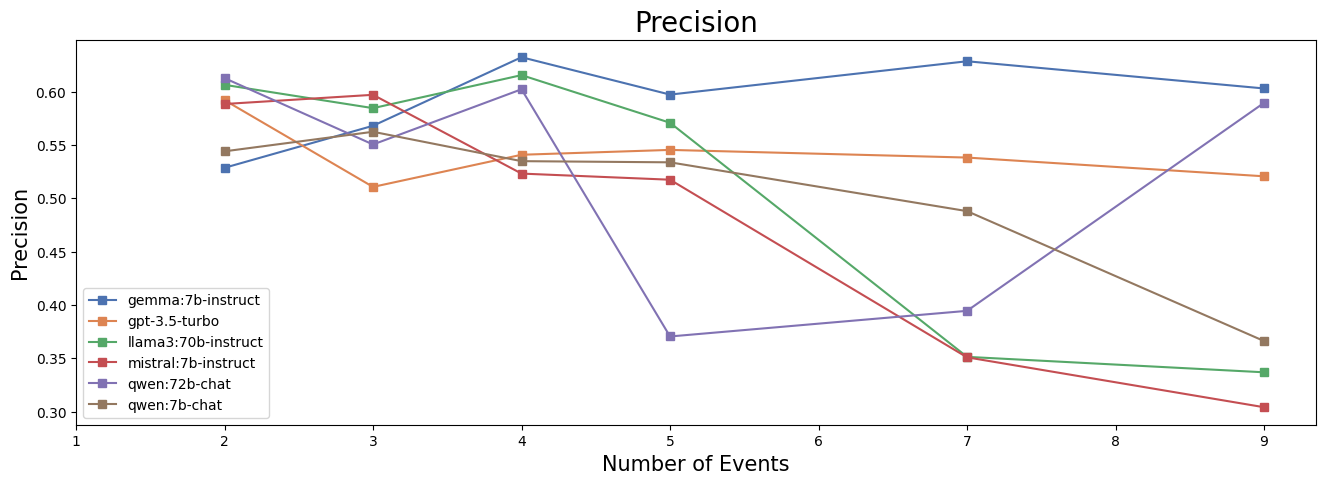

In [3146]:
x_ticks = list(np.arange(1, 10))
y_ticks = list(np.arange(0.3, 0.65, 0.05))
plot_lines(models_data_df, x='number_of_events', y='precision', z='model', title='Precision', x_label='Number of Events',
           y_label='Precision', x_ticks=x_ticks, y_ticks=y_ticks)

### 3.3. Recall

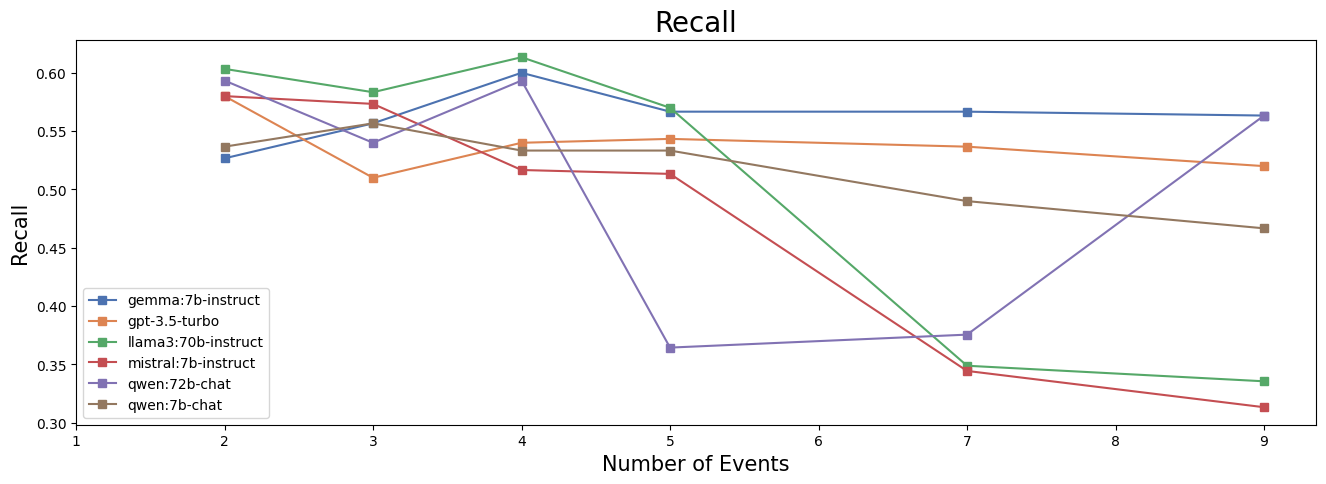

In [3147]:
x_ticks = list(np.arange(1, 10))
y_ticks = list(np.arange(0.3, 0.65, 0.05))
plot_lines(models_data_df, x='number_of_events', y='recall', z='model', title='Recall', x_label='Number of Events',
           y_label='Recall', x_ticks=x_ticks, y_ticks=y_ticks)

### 3.4. F1

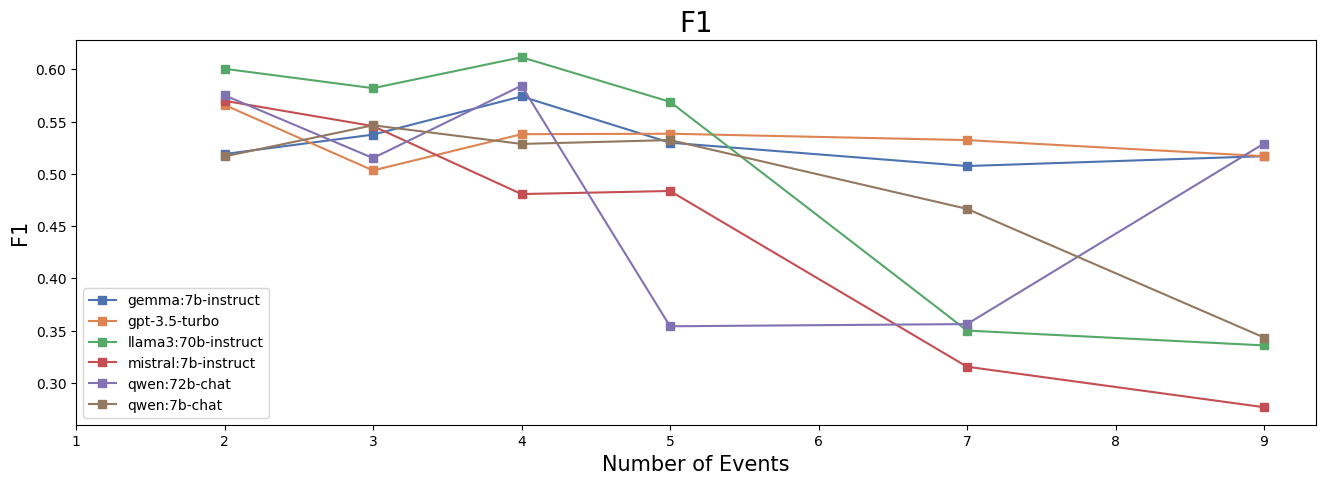

In [3148]:
x_ticks = list(np.arange(1, 10))
y_ticks = list(np.arange(0.3, 0.65, 0.05))
plot_lines(models_data_df, x='number_of_events', y='f1', z='model', title='F1', x_label='Number of Events', y_label='F1',
           x_ticks=x_ticks, y_ticks=y_ticks)

### 3.5. AUC

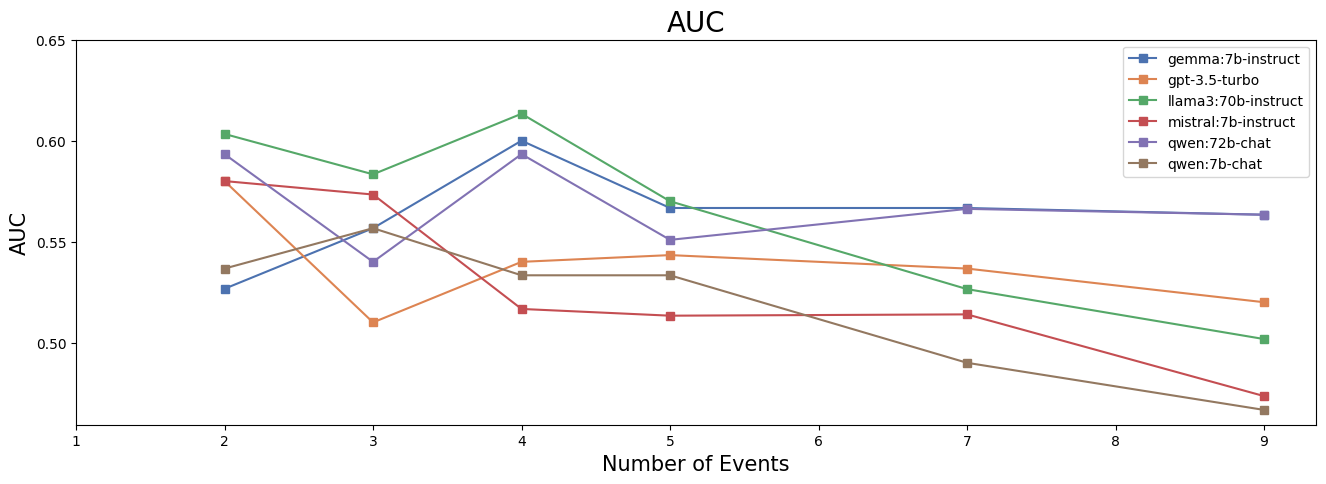

In [3149]:
x_ticks = list(np.arange(1, 10))
y_ticks = list(np.arange(0.5, 0.65, 0.05))
plot_lines(models_data_df, x='number_of_events', y='auc', z='model', title='AUC', x_label='Number of Events', y_label='AUC',
           x_ticks=x_ticks, y_ticks=y_ticks)